# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [1]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [78]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def mean_absolute_error(actual, predicted):
    """
    Berechnet den mittleren absoluten Fehler (MAE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte (z. B. gleitender Mittelwert).
        
    Returns:
        float: Der mittlere absolute Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean(np.abs(actual - predicted))

def mean_squared_error(actual, predicted):
    """
    Berechnet den mittleren quadratischen Fehler (MSE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der mittlere quadratische Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((actual - predicted) ** 2)

def mean_squared_log_error(actual, predicted):
    """
    Berechnet den mittleren logarithmischen quadratischen Fehler (MSLE).
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der MSLE.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((np.log1p(actual) - np.log1p(predicted)) ** 2)

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate the mean absolute percentage error (MAPE)
    
    Parameters:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values
    
    Returns:
        float: MAPE value in percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [96]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

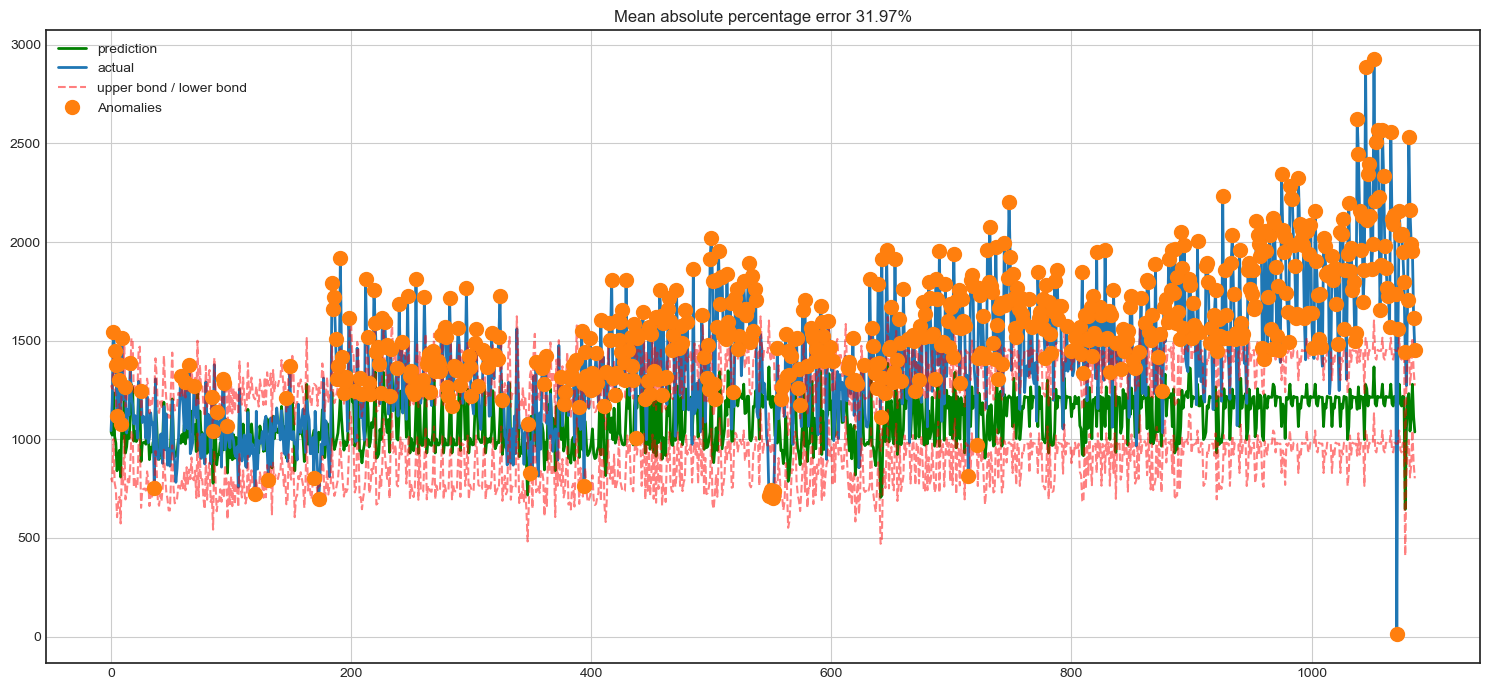

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

# Hourly Time Series Forecasting using XGBoost
https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

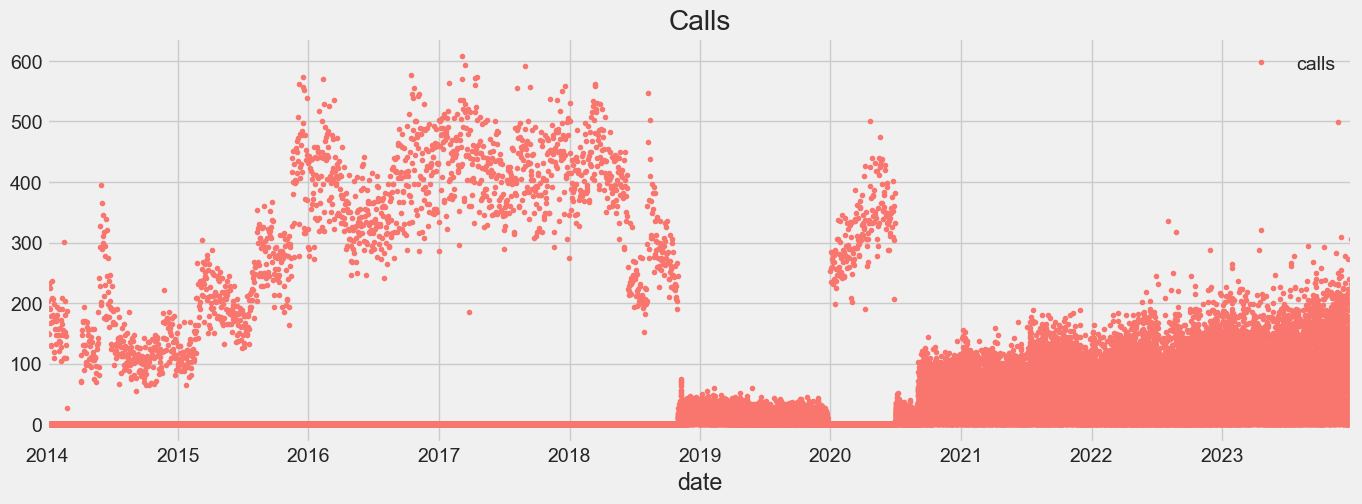

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_hourly.plot(style='.', figsize=(15,5), color=color_pal[0], title='Calls')

In [ ]:
split_date = '01-Jan-2023'
df_hourly_train = df_hourly.loc[df_hourly.index <= split_date].copy()
df_hourly_test = df_hourly.loc[df_hourly.index > split_date].copy()

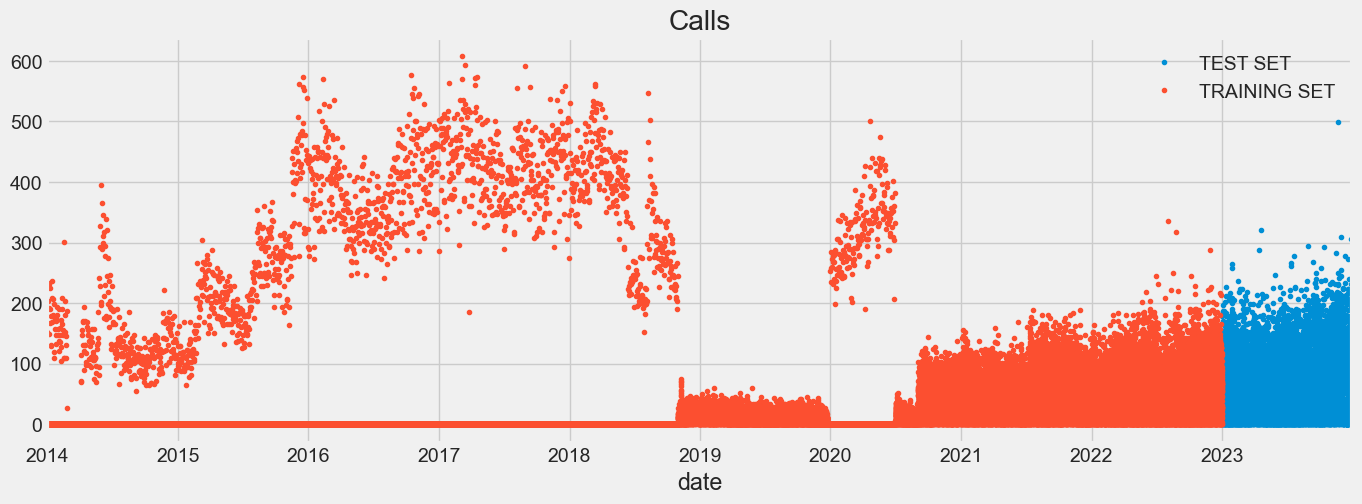

In [ ]:
_ = df_hourly_test \
    .rename(columns={'calls': 'TEST SET'}) \
    .join(df_hourly_train.rename(columns={'calls': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Calls', style='.')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(df_hourly_train, label='calls')
X_test, y_test = create_features(df_hourly_test, label='calls')

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

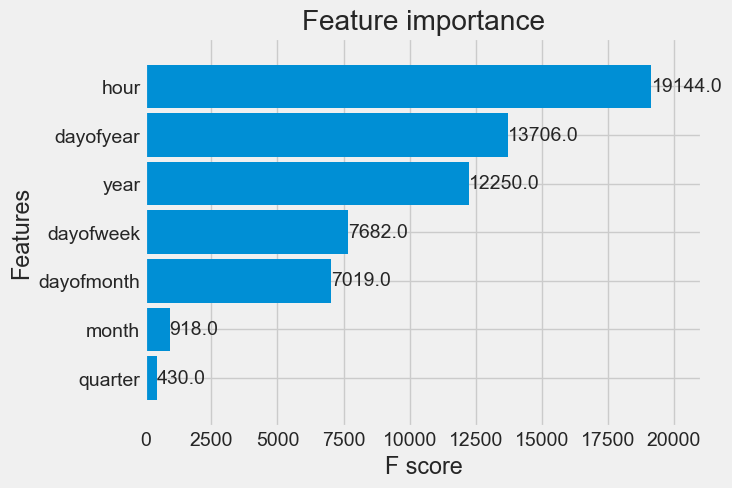

In [ ]:
_ = plot_importance(reg, height=0.9)

## Forecast on Test Set

In [ ]:
df_hourly_test['calls_prediction'] = reg.predict(X_test)
df_hourly_all = pd.concat([df_hourly_test, df_hourly_train], sort=False)

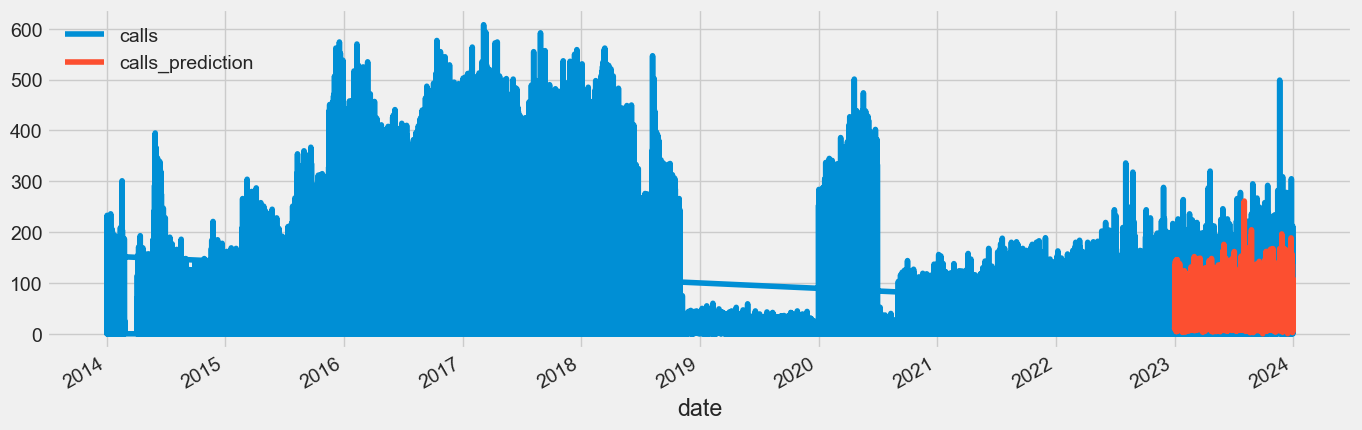

In [ ]:
_ = df_hourly_all[['calls','calls_prediction']].plot(figsize=(15, 5))

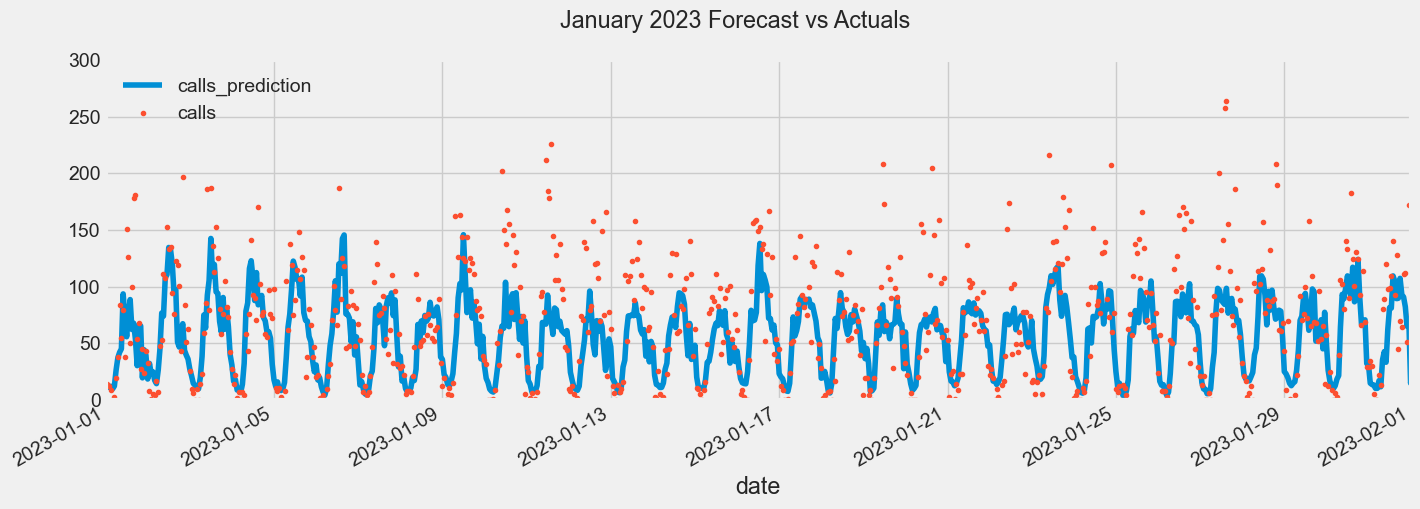

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_hourly_all[['calls_prediction','calls']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower=pd.Timestamp('01-01-2023'), upper=pd.Timestamp('02-01-2023'))
ax.set_ylim(0, 300)
plot = plt.suptitle('January 2023 Forecast vs Actuals')

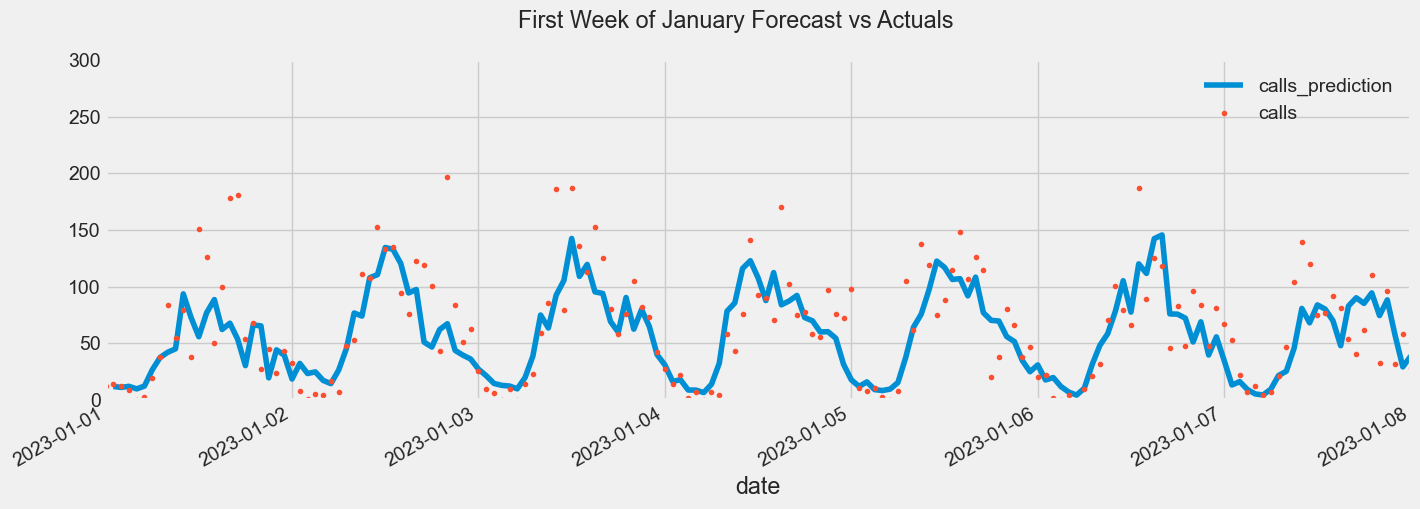

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_hourly_all[['calls_prediction','calls']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower=pd.Timestamp('01-01-2023'), upper=pd.Timestamp('01-08-2023'))
ax.set_ylim(0, 300)
plot = plt.suptitle('First Week of January Forecast vs Actuals')